#### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
from numpy import random
from networkx import linalg
import itertools
import pandas as pd
import multiprocessing as mp
import time
import csv

%matplotlib inline

In [2]:
import subprocess
import os

cmd = subprocess.Popen('pwd', stdout=subprocess.PIPE)
cmd_out, cmd_err = cmd.communicate()
local_path = os.fsdecode(cmd_out).strip()

#### Load the network data 

In [3]:
mouse_brain_network = pd.read_pickle('../data/mouse_brain_vasc_network_2018.pkl')

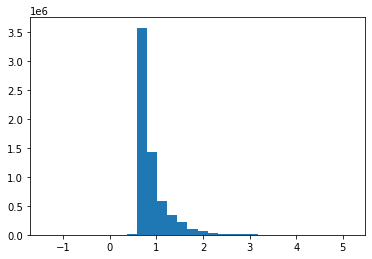

In [4]:
plt.hist(np.log(mouse_brain_network['dt']),bins=30);

In [5]:
mouse_brain_network.head(5)

,V1,VX1,VY1,VZ1,V2,VX2,VY2,VZ2,dt,length
0,1.0,3030.0,3891.0,4.0,327.0,3030.333333,3889.00,19.666667,1.878005,33.828427
1,2.0,2463.0,3822.0,6.0,1105.0,2429.000000,3828.00,40.000000,1.878005,39.828427
2,14.0,2590.0,3882.0,7.0,362.0,2666.000000,3873.25,20.750000,11.729006,16.388905
3,3.0,2605.0,3895.0,6.0,14.0,2590.000000,3882.00,7.000000,2.800137,58.211746
4,3.0,2605.0,3895.0,6.0,682.0,2620.000000,3919.00,30.000000,2.995352,21.609637


In [ ]:
# H = nx.MultiGraph()
# edges = {}
# for k in range(len(mouse_brain_network)):
#     edge = (int(mouse_brain_network['V1'][k]),int(mouse_brain_network['V2'][k]))
#     if edge in edges:
#         edges[edge].append(mouse_brain_network['dt'][k])
#     else:
#         edges[edge] = [mouse_brain_network['dt'][k]]
# result = map(lambda x:len(x[1]),list(edges.items()))
# edge_list = []
# for edge,k in zip(edges,list(result)):
#     if (k > 1) and (edge not in edge_list):
#         for i in range(len(edges[edge])):
#             edge_list.append((edge[0],edge[1],{'weight':edges[edge][i]}))
# for edge in edge_list:
#     H.add_edge(edge[0],edge[1],weight=edge[2]['weight'])

In [ ]:
# edge_list = {}
# for edge in list(H.edges.data()):
#     e = (edge[0],edge[1])
#     if e in edge_list:
#         edge_list[e].append(edge[2]['weight'])
#     else:
#         edge_list[e] = [edge[2]['weight']]

In [ ]:
# K = H.__class__()
# K.add_nodes_from(H);
# K.add_edges_from(H.edges);
# biggest_component = []
# bridges = []
# for edge in list(H.edges.data()):
#     K.remove_edge(edge[0],edge[1])
#     components = sorted(nx.connected_components(K), key = len, reverse = True)
#     if len(components)>1:
#         bridges.append(edge)
#         if len(components[1]) > len(biggest_component):
#             biggest_component = components[0]
#     K.add_edge(edge[0],edge[1],weight=edge[2]['weight'])

#### Function to extract closed trivalent graphs by sampling and trimming 

In [6]:
def spherical_region_sampling(central_node, radius):
    """
    returns points within the sampling sphere centered at the zeroth node 
    """

    dist_from_zeroth_node = np.sqrt((central_node[0]-mouse_brain_network['VX1'])**2\
                                    +(central_node[1]-mouse_brain_network['VY1'])**2\
                                    +(central_node[2]-mouse_brain_network['VZ1'])**2)
    T = np.asarray(dist_from_zeroth_node < radius)
    indices = np.argwhere(T == True).flatten()
    return indices

In [17]:
def box_sampling(lb,delta,ax):
    """
    returns indices of points that are contained in a box
    """
    d = {'X':['VX1','VX2'],'Y':['VY1','VY2'],'Z':['VZ1','VZ2']}     
    indices1 = list(mouse_brain_network[(mouse_brain_network[d[ax][0]] <= lb+delta) \
                                         & (mouse_brain_network[d[ax][0]] >= lb)].index)
    indices2 = list(mouse_brain_network[(mouse_brain_network[d[ax][1]] <= lb+delta) \
                                         & (mouse_brain_network[d[ax][1]] >= lb)].index)
    if indices1 and indices2:
        indices = np.intersect1d(np.array(indices1),np.array(indices2)).flatten()
    return indices

In [8]:
from scipy.stats import hmean 

def eff_radius(weights,combination):
    resistances = [l/r**2 for r,l in weights]
    if combination == 'parallel':
        eff_resistance = hmean(resistances)/len(resistances)
        eff_length = np.mean([l for r,l in weights])
    else:
        eff_resistance = sum(resistances)
        eff_length = sum([l for r,l in weights])
    return math.sqrt(eff_length/eff_resistance)

#### choosing to look around a vessel whose thickness lies in the range [r_l,r_u]

In [9]:
def trimming(g):
    """
    Graphs are reduced to trivalent closed graphs
    """
    components = sorted(nx.connected_components(g), key = len, reverse = True)
    if len(components)>1:
        for i in range(1,len(components)):
            for j in range(len(components[i])):
                g.remove_node(list(components[i])[j])
                        
            print(len(list(nx.connected_components(g))))
            print('Original set of smaller components removed')

    #bridges are removed here
    K = g.__class__()
    K.add_nodes_from(g);
    K.add_edges_from(g.edges);
    biggest_component = []
    bridges = []
    for edge in list(g.edges.data()):
        K.remove_edge(edge[0],edge[1])
        components = sorted(nx.connected_components(K), key = len, reverse = True)
        if len(components)>1:
            bridges.append(edge)
            if len(components[1]) > len(biggest_component):
                biggest_component = components[0]
        K.add_edge(edge[0],edge[1],dt=edge[2]['dt'],length=edge[2]['length'])
    
    for bridge in bridges:
        g.remove_edge(bridge[0],bridge[1])
        
    components = sorted(nx.connected_components(g), key = len, reverse = True)
    if len(components)>1:
        for i in range(1,len(components)):
            for j in range(len(components[i])):
                g.remove_node(list(components[i])[j])

    print('Smaller components removed')

    #final trimming to remove nodes of degree two, one and zero
    
    edge_list = {}
    for edge in list(g.edges.data()):
        e = (edge[0],edge[1])
        if e in edge_list:
            edge_list[e].append((edge[2]['dt'],edge[2]['length']))
        else:
            edge_list[e] = [(edge[2]['dt'],edge[2]['length'])]
    

    flag = True
    while flag == True:
        remove_nodes_degree_1 = []
        remove_nodes_degree_2 = []
        add_edges = []
        for n in list(g.nodes):
            adjacent = list(g.neighbors(n))
            if len(adjacent) == 1:
                remove_nodes_degree_1.append(n)
            elif len(adjacent) == 2:
                w1 = []
                w2 = []
                for k in range(2):
                    try:
                        w1.append(eff_radius(edge_list[(n,adjacent[k])],'parallel'))
                        w2.append(np.mean([y for x,y in edge_list[(n,adjacent[k])]]))
                    except KeyError as ke:
                        w1.append(eff_radius(edge_list[(adjacent[k],n)],'parallel'))
                        w2.append(np.mean([y for x,y in edge_list[(adjacent[k],n)]]))

                remove_nodes_degree_2.append(n)
                add_edges.append([adjacent[0], adjacent[1], eff_radius([(w1[k],w2[k]) for k in range(2)],'series'), sum(w2)])

        g.remove_nodes_from(remove_nodes_degree_2)
        for e in add_edges:
            g.add_edge(e[0], e[1], dt = e[2], length = e[3])
            edge_list[(e[0],e[1])] = [(e[2],e[3])]

        g.remove_nodes_from(remove_nodes_degree_1)
        
        components = sorted(nx.connected_components(g), key = len, reverse = True)
        if len(components)>1:
            for i in range(1,len(components)):
                for j in range(len(components[i])):
                    g.remove_node(list(components[i])[j])
                    
        flag = False
        print(len(g.nodes()))
        for n in list(g.nodes):
            if (len(list(g.neighbors(n))) < 3) \
            and len(np.argwhere(np.asarray(sorted(d for n, d in g.degree())) >= 3)):
                flag = True

    edge_list = {}
    for edge in list(g.edges.data()):
        e = (edge[0],edge[1])
        if e in edge_list:
            edge_list[e].append((edge[2]['dt'],edge[2]['length']))
        else:
            edge_list[e] = [(edge[2]['dt'],edge[2]['length'])]
    
    print(len(list(nx.connected_components(g))))
    H = nx.Graph()        
    for edge in edge_list:
        if len(edge_list[(edge[0],edge[1])]) == 1:
            H.add_edge(edge[0],edge[1],weight=edge_list[(edge[0],edge[1])][0][0])
        else:
            H.add_edge(edge[0],edge[1],weight=eff_radius(edge_list[(edge[0],edge[1])],'parallel'))
            
    return H

In [10]:
from scipy.stats import iqr

iqr = iqr(mouse_brain_network.dt)
dt_med = mouse_brain_network.dt.describe()['50%']
dt_first_quartile = mouse_brain_network.dt.describe()['25%']
dt_third_quartile = mouse_brain_network.dt.describe()['75%']
dt_outliers = [x for x in mouse_brain_network.dt if (x>dt_third_quartile + 1.5*iqr) or (x<dt_first_quartile - 1.5*iqr)]

##### Roughly 11 (for the 2019 and 2018 datasets, 9% for the 2020 dataset) percent of the vessels have thicknesses that are outliers according to the std. definition of outliers

In [12]:
print(100*len(dt_outliers)/len(mouse_brain_network.dt))

11.634157604631437


In [13]:
## for the 2020 dataset
#r_l = dt_third_quartile+220*iqr
## for the 2019 dataset
#r_l = dt_third_quartile+300*iqr
## for the 2018 dataset
r_l = dt_third_quartile+235*iqr
r_u = max(mouse_brain_network.dt)
radius = 300.0

# the set of edges
arr = set(mouse_brain_network[mouse_brain_network['dt'] > r_l].index) - set(mouse_brain_network[mouse_brain_network['dt'] > r_u].index)

In [15]:
def top_analysis(edge_index, radius = radius, sampling_method='spherical', delta_thickness = None, box = None, size = None, trim = True, grading_on_thickness = False):
    """
    This function takes as inputs an edge of thickness within a certain predefined range and the radius of
    the sampling sphere, and returns a closed trivalent graph along with estimated node density, vessel length
    density, sampling radius, the central node and the incident edge that was entered as the input.
    """
    if sampling_method == 'spherical':
        center = (mouse_brain_network['VX1'][edge_index],mouse_brain_network['VY1'][edge_index],\
                                             mouse_brain_network['VZ1'][edge_index])
        print(center)
        indices = spherical_region_sampling(center,radius)
    else:
            indicesx = box_sampling(box[0],size,'X')
            indicesz = box_sampling(box[2],size,'Z')
            indices = np.intersect1d(indicesx,indicesz).flatten()
            indices = np.intersect1d(indices,box_sampling(box[1],size,'Y')).flatten()
    
    G = nx.MultiGraph()
    for k in indices:
        G.add_edge(int(mouse_brain_network['V1'][k]), int(mouse_brain_network['V2'][k]), \
                   dt = mouse_brain_network['dt'][k], length = mouse_brain_network['length'][k])
    
    vl_density = 0.0
    for e in list(G.edges.data()):
        vl_density = vl_density + e[2]['length']

        if sampling_method == "spherical":
            vl_density = vl_density/(radius**3)
            node_density = len(G.nodes())/(radius**3)
        else:
            vl_density = vl_density/(size**3)
            node_density = len(G.nodes())/(size**3)
    
    if trim:
        if sampling_method == "spherical":
            return [trimming(G), edge_index, center[0], center[1], center[2], radius, vl_density, node_density]
        else:
            return [trimming(G), initx, inity, initz, size, node_density, vl_density]
        
    else:
        if sampling_method == "spherical":
            return [G, edge_index, center[0], center[1], center[2], radius, node_density, vl_density]
        else:
            return [G, initx, inity, initz, size, node_density, vl_density]

#### Setting up asynchronous parallel jobs

In [20]:
## Recommend giving slices of list arr with size equal to that of the number of jobs
pool = mp.Pool(2)

start = time.process_time()
arr = list(arr)

results = [pool.apply_async(top_analysis, args=(edge_index, radius)) for edge_index in list(arr)]
pool.close()
pool.join()

finish = time.process_time()
print(f'Time take in seconds: {round(finish-start,2)}')

#### Writing the output to a csv file

In [18]:
# change the integer inside the fstring to avoid overwriting files or use tag "a" for append while writing 
# in the next cell
output = [p.get() for p in results]
s = 'mouse_brain_data_eff_radii_' + str(int(r_l)) + '_' + str(int(r_u)) + f'_{0}_'  + str(int(radius)) + '.csv'
print(s)

mouse_brain_data_eff_radii_153_172_0_300.csv


In [22]:
with open('../trimmed_networks/'+s, 'w+') as fh:
    writer = csv.writer(fh)
    for g in output:
        print(len(g[0].nodes()))
        if len(g[0].nodes()) >= 500 and len(g[0].nodes()) <= 2000:
            writer.writerow([0,0,0,0,0]) ## a filler line to separate different network samples
            writer.writerow([g[1], g[2], g[3], g[4], g[5], g[6], g[7]])
            for t in list(g[0].edges.data()):
                writer.writerow([t[0],t[1],t[2]['weight']])